In [1]:
%load_ext autoreload
%load_ext autotime

time: 225 µs (started: 2024-12-12 19:32:21 -08:00)


In [2]:
import os
import sys
import time
import warnings
from bokeh.io import output_notebook

# Add WisIO to the path
sys.path.append(os.path.abspath("../"))

# Filter warnings
warnings.filterwarnings('ignore')

# Set the notebook to display Bokeh plots
output_notebook()

Loading BokehJS ...

time: 592 ms (started: 2024-12-12 19:32:21 -08:00)


In [3]:
analyzer = "dftracer"

run_dir = f".wisio/{analyzer}/{int(time.time())}"
bottleneck_dir = f"{run_dir}/bottlenecks"
checkpoint_dir = f"{run_dir}/checkpoints"

cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:46423"

checkpoint = False
exclude_characteristics = ['node_count', 'app_count', 'proc_count', 'file_count']
logical_view_types = False
percentile = 0.95
time_granularity = 1e6
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/cm1/APP/node-1/v1/RAW/*.pfw.gz"

app_metrics = [
    'intensity',
    'io_compute_per',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    'time_norm',
    'time_per',
    # 'u_checkpoint_io_time',
    # 'u_io_time_per',
    # 'u_read_io_time',
]
dataloader_metrics = [
    'intensity',
    # 'io_bw',
    # 'io_time_norm',
    # 'io_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]
posix_metrics = [
    'intensity',
    'data_bw',
    'data_time_norm',
    'data_time_per',
    'ops',
    # 'read_bw',
    'time_norm',
    'time_per',
    # 'write_bw',
]

app_view_types = ['proc_name', 'time_range']
dataloader_view_types = ['proc_name', 'time_range']
posix_view_types = ['proc_name', 'time_range']

time_view_type = 'time_range'
unoverlapped_posix_only = False

output_compact = False
output_group_behavior = False
output_max_bottlenecks = 1
output_root_only = True


time: 1.47 ms (started: 2024-12-12 19:32:22 -08:00)


In [4]:
# Parameters
analyzer = "dftracer"
bottleneck_dir = "/p/lustre3/iopp/wisio-bottlenecks/dftracer-bert-v100-node-16-v3-proc_name-time_range"
checkpoint = True
checkpoint_dir = "/p/lustre3/iopp/wisio-checkpoints/dftracer-bert-v100-node-16-v3-proc_name-time_range"
cluster = "external"
cluster_restart_on_connect = True
cluster_scheduler_address = "tcp://127.0.0.1:36047"
logical_view_types = False
output_max_bottlenecks = 3
output_root_only = False
percentile = 0.6
run_dir = ".wisio/dftracer-bert-v100-node-16-v3-proc_name-time_range"
time_granularity = 1000000.0
trace_path = "/p/lustre3/iopp/dftracer-traces-lfs/v1.0.5-develop/corona/bert/v100/node-16/v3/COMPACT/*.pfw.gz"

app_view_types = ["proc_name", "time_range"]
dataloader_view_types = ["proc_name", "time_range"]
posix_view_types = ["proc_name", "time_range"]


time: 1.55 ms (started: 2024-12-12 19:32:22 -08:00)


In [5]:
from distributed import Client
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from hydra.utils import instantiate
from wisio.cluster import ExternalCluster
from wisio.config import init_hydra_config_store
from wisio.utils.file_utils import ensure_dir

ensure_dir(run_dir)

with initialize(version_base=None, config_path=None):
    init_hydra_config_store()
    cfg = compose(
        config_name="config",
        overrides=[
            f"+analyzer={analyzer}",
            f"analyzer.bottleneck_dir={bottleneck_dir}",
            f"analyzer.checkpoint={checkpoint}",
            f"analyzer.checkpoint_dir={checkpoint_dir}",
            f"analyzer.time_granularity={time_granularity}",
            # f"cluster={cluster}",
            # f"cluster.restart_on_connect={cluster_restart_on_connect}",
            # f"cluster.scheduler_address={cluster_scheduler_address}",
            "cluster=external",
            "cluster.scheduler_address=tcp://127.0.0.1:46065",
            f"exclude_characteristics=[{','.join(exclude_characteristics)}]",
            f"hydra.run.dir={run_dir}",
            f"hydra.runtime.output_dir={run_dir}",
            f"logical_view_types={logical_view_types}",
            f"output.compact={output_compact}",
            f"output.group_behavior={output_group_behavior}",
            f"output.max_bottlenecks={output_max_bottlenecks}",
            f"output.root_only={output_root_only}",
            f"percentile={percentile}",
            f"trace_path={trace_path}",
        ],
        return_hydra_config=True,
    )
    HydraConfig.instance().set_config(cfg)
    cluster = instantiate(cfg.cluster)
    if isinstance(cluster, ExternalCluster):
        client = Client(cluster.scheduler_address)
        if cluster.restart_on_connect:
            client.restart()
    else:
        client = Client(cluster)
    analyzer = instantiate(cfg.analyzer)
    output = instantiate(cfg.output)

time: 2.82 s (started: 2024-12-12 19:32:22 -08:00)


In [6]:
client.dashboard_link

'http://127.0.0.1:8787/status'

time: 7.15 ms (started: 2024-12-12 19:32:25 -08:00)


In [7]:
client.restart()

<Client: 'tcp://127.0.0.1:46065' processes=5 threads=5>

time: 3.63 s (started: 2024-12-12 19:32:25 -08:00)


In [8]:
from wisio.constants import Layer

result = analyzer.analyze_trace(
    trace_path=cfg.trace_path,
    bottleneck_rules=cfg.bottleneck_rules,
    exclude_bottlenecks=cfg.exclude_bottlenecks,
    exclude_characteristics=cfg.exclude_characteristics,
    logical_view_types=cfg.logical_view_types,
    percentile=cfg.percentile,
    metrics={
        'dlio': app_metrics,
        'compute': app_metrics,
        'dataloader': dataloader_metrics,
        'image': dataloader_metrics,
        'reader': dataloader_metrics,
        'checkpoint': dataloader_metrics,
        'posix': posix_metrics,
    },
    time_view_type=time_view_type,
    unoverlapped_posix_only=unoverlapped_posix_only,
    view_types={
        'dlio': app_view_types,
        'compute': app_view_types,
        'dataloader': dataloader_view_types,
        'image': dataloader_view_types,
        'reader': dataloader_view_types,
        'checkpoint': dataloader_view_types,
        'posix': posix_view_types,
    },
)

time: 1min 23s (started: 2024-12-12 19:32:29 -08:00)


In [9]:
traces, hlms, main_views, metric_boundaries, views, flat_views = result

time: 670 µs (started: 2024-12-12 19:33:52 -08:00)


In [17]:
traces.to_parquet(f"{checkpoint_dir}/_traces", write_metadata_file=True)

time: 3.93 s (started: 2024-12-12 19:43:37 -08:00)


In [10]:
flat_views[('time_range',)].sort_index().to_csv('bert_node16_time_range.csv')

time: 685 ms (started: 2024-12-12 19:33:52 -08:00)


In [11]:
flat_views[('proc_name',)].sort_index().to_csv('bert_node16_proc_name.csv')

time: 1.19 s (started: 2024-12-12 19:33:53 -08:00)


In [12]:
flat_views[('proc_name', 'proc_id')].sort_index().to_csv('bert_node16_proc_id.csv')

time: 89.3 ms (started: 2024-12-12 19:33:54 -08:00)


In [13]:
flat_views[('proc_name', 'host_name')].sort_index().to_csv('bert_node16_host_name.csv')

time: 52 ms (started: 2024-12-12 19:33:54 -08:00)


In [15]:
import pandas as pd


time: 634 µs (started: 2024-12-12 19:43:06 -08:00)


<Axes: >

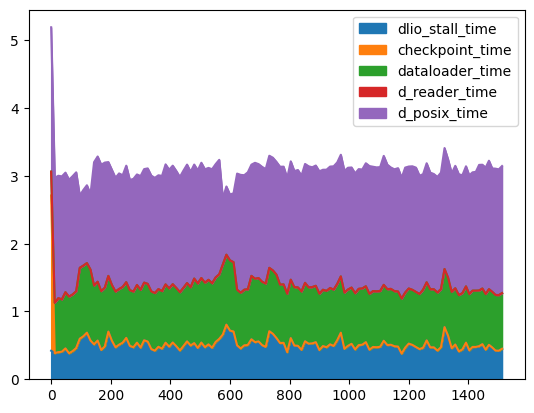

time: 909 ms (started: 2024-12-12 19:43:07 -08:00)


In [16]:
pd.read_csv('bert_node16_proc_name.csv').sort_index().query('dlio_compute_time > 0')[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'd_reader_time',
        # 'dataloader_sample_time',
        'd_posix_time',
    ]
].plot(kind='area')

<Axes: >

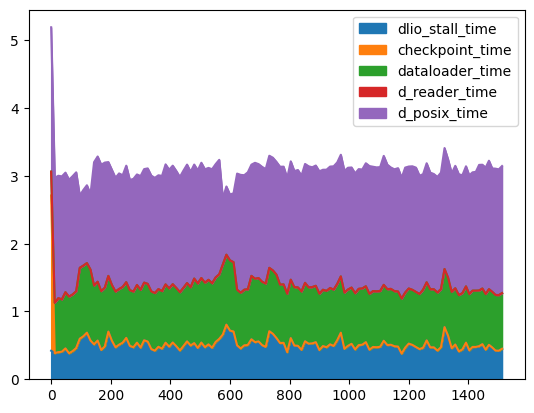

time: 879 ms (started: 2024-12-09 11:24:32 -08:00)


In [16]:
pd.read_csv('bert_node16_proc_name.csv').sort_index().query('dlio_compute_time > 0')[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        # 'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'd_reader_time',
        # 'dataloader_sample_time',
        'd_posix_time',
    ]
].plot(kind='area')

<Axes: >

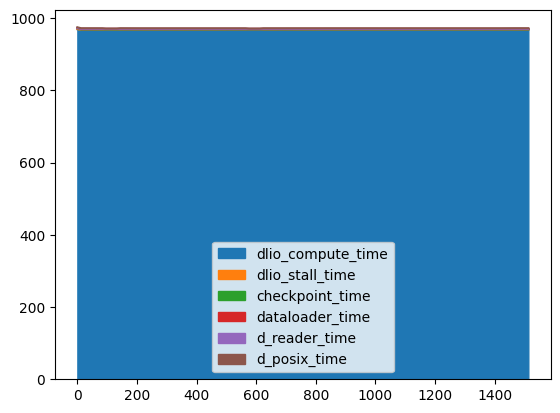

time: 350 ms (started: 2024-12-09 11:25:33 -08:00)


In [21]:
pd.read_csv('bert_node16_proc_name.csv').sort_index().query('dlio_compute_time > 0')[
    # ['dlio_compute_time', 'dlio_stall_time', 'posix_time']
    [
        # 'compute_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'checkpoint_time',
        'dataloader_time',
        'd_reader_time',
        # 'dataloader_sample_time',
        'd_posix_time',
    ]
].plot(kind='area')

In [22]:
pd.read_csv('bert_node16_time_range.csv')[
    [
        'compute_time',
        'checkpoint_time',
        'dlio_compute_time',
        'dlio_stall_time',
        'dataloader_time',
        'dataloader_sample_time',
        'posix_time',
        'u_checkpoint_time',
        'u_dataloader_time',
        'u_dataloader_sample_time',
        'u_posix_time',
    ]
].sum()

compute_time                969.978840
checkpoint_time               2.290543
dlio_compute_time           971.569023
dlio_stall_time               1.193137
dataloader_time               1.046945
dataloader_sample_time        0.000000
posix_time                    5.164257
u_checkpoint_time             2.172975
u_dataloader_time             0.077911
u_dataloader_sample_time      0.000000
u_posix_time                  3.004827
dtype: float64

time: 53.5 ms (started: 2024-12-09 11:25:40 -08:00)


<Axes: >

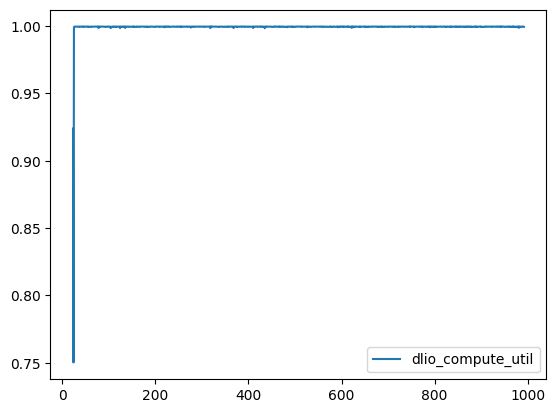

time: 220 ms (started: 2024-12-08 17:44:04 -08:00)


In [27]:
pd.read_csv('bert_node16_time_range.csv').query('dlio_stall_time > 0')[
    [
        # 'compute_time',
        # 'checkpoint_time',
        'dlio_compute_util',
        # 'dlio_stall_time',
        # 'dataloader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'u_dataloader_sample_time',
        # 'u_posix_time',
    ]
].plot()

<Axes: >

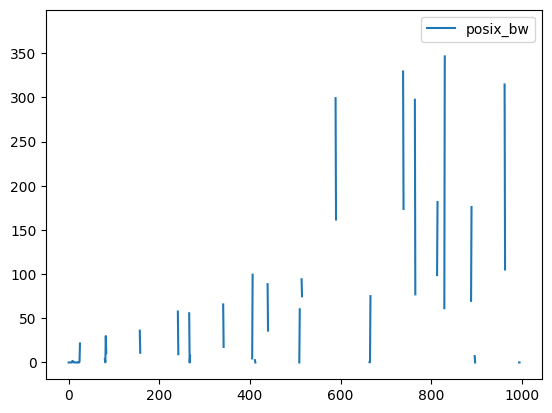

In [9]:
(pd.read_csv('bert_node16_time_range.csv')[
    [
        # 'compute_time',
        # 'checkpoint_time',
        'posix_bw',
        # 'dlio_stall_time',
        # 'dataloader_time',
        # 'dataloader_sample_time',
        # 'posix_time',
        # 'u_checkpoint_time',
        # 'u_dataloader_time',
        # 'u_dataloader_sample_time',
        # 'u_posix_time',
    ]
] / 1024 ** 3).plot()

<Axes: >

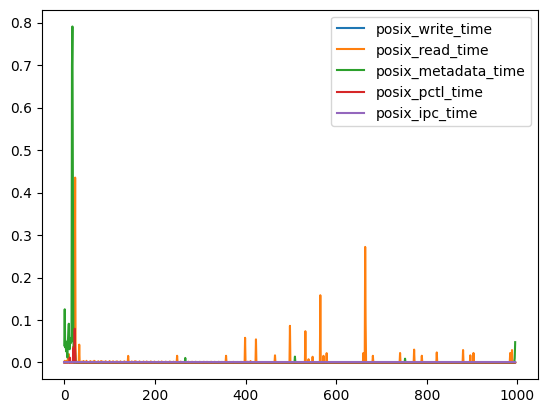

In [10]:
(
    pd.read_csv('bert_node16_time_range.csv')[
        [
            # 'compute_time',
            # 'checkpoint_time',
            # 'posix_bw',
            # 'dlio_stall_time',
            # 'dataloader_time',
            # 'dataloader_sample_time',
            # 'posix_time',
            # 'u_checkpoint_time',
            # 'u_dataloader_time',
            # 'u_dataloader_sample_time',
            # 'u_posix_time',
            'posix_write_time',
            'posix_read_time',
            'posix_metadata_time',
            'posix_pctl_time',
            'posix_ipc_time',
        ]
    ]
).plot()

In [23]:
import pandas as pd 
from wisio.metrics import set_metric_scores

time_range_view = pd.read_csv('bert_node16_time_range.csv').copy().set_index('time_range')
# time_range_view = pd.read_csv('cosmoflow_node4_proc_name.csv').copy().set_index('proc_name')
time_range_view.index = time_range_view.index.astype(str)

time_range_view['reader_r3_time'] = time_range_view['reader_time'].rolling(window=3).mean()
time_range_view['reader_r3_gauss_time'] = time_range_view['reader_time'].rolling(window=3, win_type='gaussian').mean(std=1)
time_range_view['reader_r3_hann_time'] = time_range_view['reader_time'].rolling(window=3, win_type='hann').mean()

time_range_view['reader_r3_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_r3_time'].sum()
time_range_view['reader_r3_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_r3_gauss_time'].sum()
time_range_view['reader_r3_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_r3_hann_time'].sum()

time_range_view['reader_r3_2_time_per'] = time_range_view['reader_r3_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_gauss_time_per'] = time_range_view['reader_r3_gauss_time'] / time_range_view['reader_time'].sum()
time_range_view['reader_r3_2_hann_time_per'] = time_range_view['reader_r3_hann_time'] / time_range_view['reader_time'].sum()

time_range_view['reader_r3_time_norm'] = time_range_view['reader_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_gauss_time_norm'] = time_range_view['reader_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['reader_r3_hann_time_norm'] = time_range_view['reader_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

time_range_view['posix_read_r3_time'] = time_range_view['posix_read_time'].rolling(window=10).sum()
time_range_view['posix_read_r3_gauss_time'] = time_range_view['posix_read_time'].rolling(window=10, win_type='gaussian').sum(std=1)
time_range_view['posix_read_r3_hann_time'] = time_range_view['posix_read_time'].rolling(window=10, win_type='hann').sum()

time_range_view['posix_read_r3_time_per'] = time_range_view['posix_read_r3_time'] / time_range_view['posix_read_r3_time'].sum()
time_range_view['posix_read_r3_gauss_time_per'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view['posix_read_r3_gauss_time'].sum()
time_range_view['posix_read_r3_hann_time_per'] = time_range_view['posix_read_r3_hann_time'] / time_range_view['posix_read_r3_hann_time'].sum()

time_range_view['posix_read_r3_time_norm'] = time_range_view['posix_read_r3_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_gauss_time_norm'] = time_range_view['posix_read_r3_gauss_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()
time_range_view['posix_read_r3_hann_time_norm'] = time_range_view['posix_read_r3_hann_time'] / time_range_view[['dlio_time', 'dataloader_time', 'checkpoint_time', ]].sum().sum()

# time_range_view['dlio_compute_util'] = time_range_view['dlio_compute_time'].astype(
#     float
# ) / (
#     time_range_view['dlio_compute_time'].astype(float)
#     + time_range_view['dlio_stall_time'].astype(float)
#     # + time_range_view['checkpoint_time'].astype(float)
# )

time_range_view = set_metric_scores(time_range_view)
# time_range_view['dlio_compute_util_score'] = 8 - time_range_view['dlio_compute_util_score']
# time_range_view['dlio_compute_util_score'] = time_range_view['dlio_compute_util_score'].mask(time_range_view['dlio_compute_time'] == 0, pd.NA)

dlio_cols = ['dlio_compute_util_score'] # [col for col in time_range_view.columns if 'dlio_' in col and col.endswith('_score')]
dataloader_cols = [col for col in time_range_view.columns if 'dataloader_' in col and col.endswith('_score')]
checkpoint_cols = [col for col in time_range_view.columns if 'checkpoint_' in col and col.endswith('_score')]
posix_cols = [col for col in time_range_view.columns if 'posix_' in col and col.endswith('_score')]
# norm_cols = [col for col in time_range_view.columns if '_score' in col]
# norm_cols = ['dlio_compute_util_score'] + norm_cols
norm_cols = dlio_cols + dataloader_cols + checkpoint_cols + posix_cols

norm_cols = [col for col in norm_cols if 'slope' not in col]

norm_scores = time_range_view[norm_cols]
norm_scores

,dlio_compute_util_score,dataloader_bw_score,dataloader_compute_per_score,dataloader_count_per_score,dataloader_intensity_score,dataloader_ops_rank_score,dataloader_sample_time_norm_score,dataloader_sample_time_per_score,dataloader_time_norm_score,dataloader_time_per_score,...,u_posix_read_time_norm_score,u_posix_read_time_per_score,u_posix_seek_time_norm_score,u_posix_seek_time_per_score,u_posix_stat_time_norm_score,u_posix_stat_time_per_score,u_posix_time_norm_score,u_posix_time_per_score,u_posix_write_time_norm_score,u_posix_write_time_per_score
time_range,,,,,,,,,,,,,,,,,,,,,
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,1,2,1,1,1,2,1,3,0,0
1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,1,3,1,1,1,3,1,3,0,0
2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,1,2,1,1,1,2,1,3,0,0
3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,1,1,0,0,1,2,1,3,0,0
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,1,1,1,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1009,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1010,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


time: 893 ms (started: 2024-12-09 11:25:53 -08:00)


In [24]:
import pandas as pd

norm_scores_all = norm_scores.copy()
for col in norm_cols:
    norm_scores2 = norm_scores.copy()
    norm_scores2['score_col'] = col
    norm_scores2['score'] = norm_scores2[col]
    norm_scores_all = pd.concat([norm_scores_all, norm_scores2])
norm_scores_all.drop(columns=norm_cols).dropna()

,score_col,score
time_range,,
40,dlio_compute_util_score,0
41,dlio_compute_util_score,1
42,dlio_compute_util_score,0
43,dlio_compute_util_score,0
44,dlio_compute_util_score,0
...,...,...
1001,u_posix_write_time_per_score,0
1005,u_posix_write_time_per_score,0
1007,u_posix_write_time_per_score,0


time: 2.7 s (started: 2024-12-09 11:25:54 -08:00)


In [25]:
from math import pi

import pandas as pd

from bokeh.models import BasicTicker, PrintfTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.palettes import RdYlGn, Reds, TolYlOrBr
from bokeh.io import output_notebook

output_notebook()


VAL_COL = 'proc_id'

years = list(time_range_view.index.astype(str))
months = list(reversed(norm_cols))

# reshape to 1D array or rates with a month and year for each row.
df = norm_scores_all.drop(
    columns=norm_cols
).reset_index().dropna()  # pd.DataFrame(data.stack(), columns=['rate']).reset_index()

# this is the colormap from the original NYTimes plot
colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]
mapper = linear_cmap(
    field_name="score",
    palette=Reds[8][::-1],  # Green-to-Red palette with 11 steps
    low=0,
    high=8,
)

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(
    # title=f"US Unemployment ({years[0]} - {years[-1]})",
    x_range=years,
    y_range=months,
    x_axis_location="above",
    width=900,
    height=400,
    tools=TOOLS,
    toolbar_location='below',
    tooltips=[('date', '@time_range'), ('score', '@score%')],
)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

r = p.rect(
    x="time_range",
    y="score_col",
    width=1,
    height=1,
    source=df,
    fill_color=mapper, # linear_cmap("score", colors, low=0, high=8),
    line_color=None,
)

p.add_layout(
    r.construct_color_bar(
        major_label_text_font_size="7px",
        ticker=BasicTicker(desired_num_ticks=len(colors)),
        formatter=PrintfTickFormatter(format="%d%%"),
        label_standoff=6,
        border_line_color=None,
        padding=5,
    ),
    'right',
)

show(p)

Loading BokehJS ...

time: 284 ms (started: 2024-12-09 11:25:57 -08:00)


Feature Importances (Random Forest):
posix_pctl_count_per_score     0.254612
posix_compute_per_score        0.169679
posix_pctl_time_per_score      0.157419
posix_pctl_ops_rank_score      0.115712
posix_read_time_per_score      0.111080
                                 ...   
posix_close_ops_rank_score     0.000000
posix_close_count_per_score    0.000000
posix_bw_score                 0.000000
image_time_per_score           0.000000
u_reader_time_per_score        0.000000
Length: 145, dtype: float64


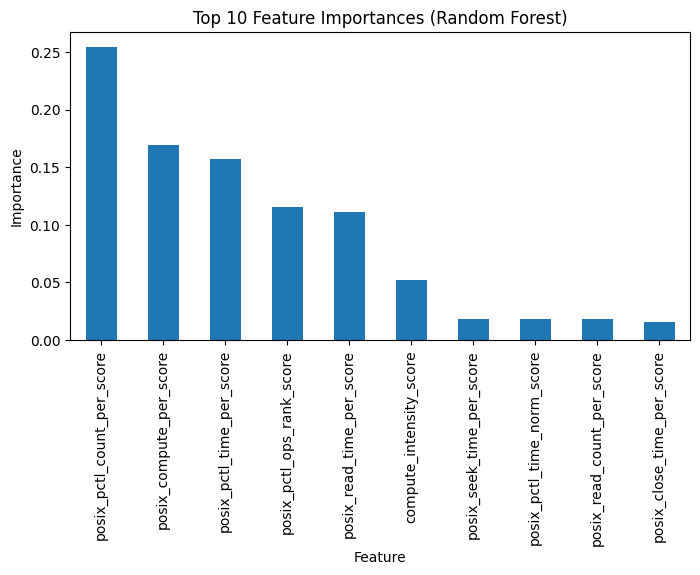

time: 330 ms (started: 2024-12-09 11:26:59 -08:00)


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Splitting data into features (X) and target (y)
# df = df.dropna()
df = pd.read_csv('bert_node16_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target].fillna(0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display top features
print("Feature Importances (Random Forest):")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


Top correlations with 'dlio_compute_util_score':
posix_pctl_ops_rank_score             1.000000
dlio_compute_util_score               1.000000
posix_pctl_time_norm_score            0.705708
posix_seek_time_norm_score            0.705708
posix_seek_time_per_score             0.705708
                                        ...   
u_reader_preprocess_time_per_score         NaN
u_reader_sample_time_norm_score            NaN
u_reader_sample_time_per_score             NaN
u_reader_time_norm_score                   NaN
u_reader_time_per_score                    NaN
Name: dlio_compute_util_score, Length: 146, dtype: float64


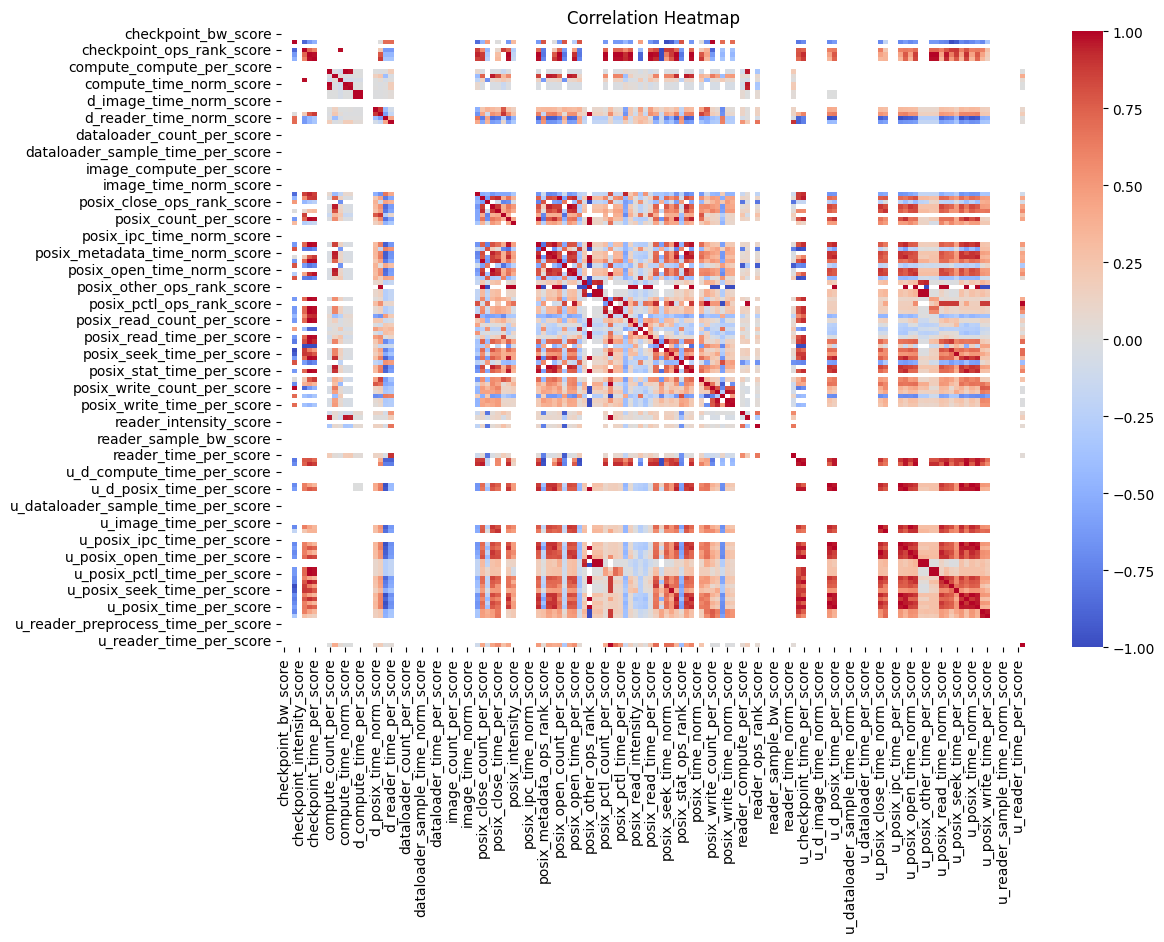

time: 939 ms (started: 2024-12-09 11:27:14 -08:00)


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your dataframe containing the scores

df = pd.read_csv('bert_node16_time_range.csv').copy().set_index('time_range')
target = 'dlio_compute_util_score'
# target = 'dlio_stall_time_per_score'
score_cols = [col for col in df.columns if '_score' in col and 'dlio' not in col and 'slope' not in col and 'posix_data' not in col]
score_cols = score_cols + [target]
X = df[score_cols].drop(columns=[target])  # All columns except the target
y = df[target]


# df = norm_scores.copy()

# Calculate correlation matrix
correlation_matrix = df[score_cols].copy().corr()

# Focus on correlations with 'dlio_compute_util_score'
target_correlation = correlation_matrix[target].sort_values(ascending=False)

# Print correlations
print("Top correlations with 'dlio_compute_util_score':")
print(target_correlation)

# Plot a heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Optional: Heatmap focusing only on top 10 correlated features
# top_features = target_correlation.index[:10]  # Top 10 features
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0, cbar=True)
# plt.title('Heatmap of Top 10 Correlated Features with dlio_compute_util_score')
# plt.show()


In [8]:
analyzer.write_bottlenecks(result.flat_bottlenecks)

time: 612 ms (started: 2024-11-11 12:06:45 -08:00)


In [9]:
output.handle_result(metrics=[], result=result)

╭──────────────────────────────────────────── APP I/O Characteristics ────────────────────────────────────────────╮
│                                                                                                                 │
│  App Time  Runtime: 1029.25 seconds (100%)                                                                      │
│            ├── Application I/O Time: 0.15 seconds (0.01%)                                                       │
│            ├── Checkpoint I/O Time: 0.15 seconds (0.01%)                                                        │
│            ├── Compute Time: 969.98 seconds (94.24%)                                                            │
│            ├── I/O Time: 5.16 seconds (0.50%)                                                                   │
│            ├── Read I/O Time: 0.00 seconds (0.00%)                                                              │
│            ├── Time: 1950.27 seconds (189.48%)                                                                  │
│            ├── Unoverlapped Application I/O Time: 0.03 seconds (0.00%)                                          │
│            ├── Unoverlapped Checkpoint I/O Time: 0.03 seconds (0.00%)                                           │
│            ├── Unoverlapped Compute Time: 967.82 seconds (94.03%)                                               │
│            ├── Unoverlapped I/O Time: 3.00 seconds (0.29%)                                                      │
│            ├── Unoverlapped Read I/O Time: 0.00 seconds (0.00%)                                                 │
│            └── Unoverlapped Application Compute Time: 969.86 seconds (94.23%)                                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭──────────────────────────────────────── DATALOADER I/O Characteristics ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
                                                                                                                   
╭─────────────────────────────────────────── POSIX I/O Characteristics ───────────────────────────────────────────╮
│                                                                                                                 │
│  Runtime         1029.25 seconds                                                                                │
│  I/O Time        5.16 seconds (100%)                                                                            │
│                  ├── Read: 2.12 seconds (40.96%)                                                                │
│                  ├── Write: 0.01 seconds (0.11%)                                                                │
│                  └── Metadata: 2.95 seconds (57.19%)                                                            │
│  I/O Ops.        8,827,967 ops                                                                                  │
│                  ├── Read - 287,384 ops (3.26%)                                                                 │
│                  ├── Write - 4,015 ops (0.05%)                                                                  │
│                  └── Metadata - 8,365,048 ops (94.76%)                                                          │
│  I/O Size        15.46 GiB                            

time: 47.8 ms (started: 2024-11-11 12:06:46 -08:00)


In [10]:
bottlenecks = analyzer.read_bottlenecks()

time: 27.4 ms (started: 2024-11-11 12:06:46 -08:00)


In [11]:
from bokeh.io import show
from wisio.plots import plot_bottleneck_summary

show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name')))

time: 530 ms (started: 2024-11-11 12:06:46 -08:00)


In [12]:
show(plot_bottleneck_summary(bottlenecks, groupby=('layer', 'view_name', 'metric')))

time: 595 ms (started: 2024-11-11 12:06:46 -08:00)
